# Sentiment Classification 

## Importing the required libraries. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk                                                  
nltk.download('stopwords')   # Provides the stopwords to be removed from the text.
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras import losses
from keras import optimizers
from keras.callbacks import EarlyStopping 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gautam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Checking whether GPU is working. 

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Reading data stored in '.csv' file using pandas. 

In [3]:
data = pd.read_csv("IMDB Dataset.csv")

In [4]:
data.info

<bound method DataFrame.info of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

In [5]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
text_samples = data['review']
labels = data['sentiment']

## Writing preprocessing functions. 

In [7]:
from nltk.corpus import stopwords
Stopwords=set(stopwords.words('english'))

def standardization(text):
    text = re.sub(r'<.*?>',"",text) #Removes html tags.
    
    text = re.sub(r"\\","",text)
    text = re.sub(r"\"","",text)
    text = re.sub(r"\'","",text)
    
    text = text.strip().lower() 
    
    punctuation = string.punctuation
    punctuation_dict = dict((c,"") for c in punctuation)
    punctuation_map = str.maketrans(punctuation_dict)
    text = text.translate(punctuation_map)  #Removes punctuation from text.
    
    text = ' '.join(word for word in text.split() if word not in Stopwords)
    
    return text

In [8]:
def tokenization(standardized_text,Max_vocab,Max_length):   
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=Max_vocab,filters=string.punctuation)
    tokenizer.fit_on_texts(standardized_text)

    tokenized_text = tokenizer.texts_to_sequences(standardized_text)
    padded_tokenized_text = tf.keras.preprocessing.sequence.pad_sequences(tokenized_text,maxlen=Max_length)
    
    return padded_tokenized_text

In [9]:
def text_preprocessing(text,Max_vocab,Max_length):
    print(text.shape)
    standardized_text = text.apply(standardization)
    print(standardized_text.shape)
    preprocessed_text = tokenization(standardized_text,Max_vocab,Max_length)
    
    return preprocessed_text

## Splitting data into train and test sets. 

In [10]:
X_train,X_test,y_train,y_test = train_test_split(text_samples,labels,train_size=0.6,random_state=123)

In [11]:
print('Shape of X_train :',X_train.shape)
print('Shape of X_test  :',X_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_test  :',y_test.shape)

Shape of X_train : (30000,)
Shape of X_test  : (20000,)
Shape of y_train : (30000,)
Shape of y_test  : (20000,)


## Preprocessing the required text. 

In [12]:
Max_vocab=20000
Max_length=250
Embedding_dim=50

preprocessed_train = text_preprocessing(X_train,Max_vocab,Max_length)
preprocessed_test = text_preprocessing(X_test,Max_vocab,Max_length)

(30000,)
(30000,)
(20000,)
(20000,)


### One Hot encoding the labels. 

In [13]:
train_labels=pd.get_dummies(y_train)
test_labels=pd.get_dummies(y_test)

In [14]:
print('Shape of training data :',preprocessed_train.shape)
print('Shape of test data  :',preprocessed_test.shape)
print('Shape of training labels :',train_labels.shape)
print('Shape of test labels  :',test_labels.shape)

Shape of training data : (30000, 250)
Shape of test data  : (20000, 250)
Shape of training labels : (30000, 2)
Shape of test labels  : (20000, 2)


## Defining the model and running it on the training data. 

In [15]:
model=Sequential([Embedding(Max_vocab,Embedding_dim,input_length= preprocessed_train.shape[1] ),
                 SpatialDropout1D(0.2),
                 LSTM(100,dropout=0.2),
                 Dense(2)])

model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(),metrics=['accuracy'])

epochs=5
batch_size=32
callbacks=EarlyStopping(monitor='val_loss',patience=3) 
history=model.fit(preprocessed_train,train_labels,epochs=epochs,batch_size=batch_size,validation_split=0.2,callbacks=callbacks)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
748/750 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.8297WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000017E8D3D4678> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

## Plotting the loss . 

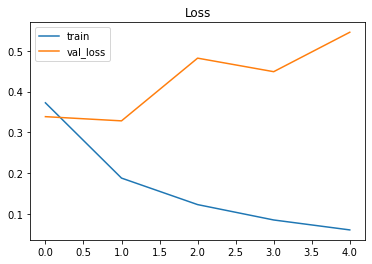

In [16]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

## Since training error is decreasing but validation error is increasing, it is a case of overfitting.

#### Techniques to prevent overfitting such as using more data and regularization should be used. Removing overfitting is beyond the purpose of this project. 

## Plotting the accuracy. 

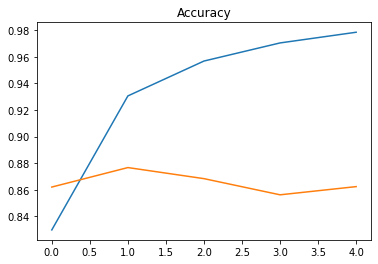

In [17]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='val_accuracy')

In [18]:
test_loss,test_accuracy=model.evaluate(preprocessed_test,test_labels)
print('Test Accuracy:',test_accuracy,'Test Loss:',test_loss)


625/625 [==============================] - 4s 7ms/step - loss: 2.1841 - accuracy: 0.4963
Test Accuracy: 0.49630001187324524 Test Loss: 2.1841273307800293
